# Project Proposal Group 15

#### By: Tony Liang, Jack Fan, Minghao Wang

## 1. Introduction

### 1.1 Background information on the topic

A growing body of research suggests that race and ethnicity may affect the infection rates of Covid-19.

Race and ethnicity can be essential factors affecting novel Coronavirus infection rates, including different socioeconomic status, the different history of degree of coronavirus exposure (Ethnic groups with less coronavirus exposure may be more susceptible to Covid-19), the easiness of access to health care and the probability of exposure to the virus concerning occupations such as hospital personnel or airport staff. Because where people live and work affects their health, over time, these factors contribute to different health risks for different racial and ethnic groups.

### 1.2 The Question 

Through this group project, we wish to answer the question: 
We want to compare whether there are specific differences in the positive and death proportion of Covid-19 among Black, White, Latin and Asian people in California and Texas.

### 1.3 The Dataset

To answer the question, we use the CRDT Data Set. This data set is based on the states' race and ethnicity reports for several COVID-19 data categories.

### 1.4 The Literature 

Text

## 2. Preliminary Results

### 2.0 Libraries and Packages

In [2]:
library(tidyverse)
library(readr)
library(tidyr)
library(dbplyr)
library(lubridate)
library(ggplot2)

-- Attaching packages ------------------------------------------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.6     v dplyr   1.0.7
v tidyr   1.1.4     v stringr 1.4.0
v readr   2.1.1     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'dbplyr'


The following objects are masked from 'package:dplyr':

    ident, sql



Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union




### 2.1 Read the data into R

In [25]:
df <- read_csv("../data/crdt-data.csv")
cat("The dimenstion of this dataframe is: ", dim(df)[1], "x", dim(df)[2])
head(df)


Rows: 5320 Columns: 54

-- Column specification ------------------------------------------------------------------------------------------------------------------------------------
Delimiter: ","
chr  (1): State
dbl (53): Date, Cases_Total, Cases_White, Cases_Black, Cases_Latinx, Cases_A...


i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.



The dimenstion of this dataframe is:  5320 x 54

Date,State,Cases_Total,Cases_White,Cases_Black,Cases_Latinx,Cases_Asian,Cases_AIAN,Cases_NHPI,Cases_Multiracial,...,Tests_Latinx,Tests_Asian,Tests_AIAN,Tests_NHPI,Tests_Multiracial,Tests_Other,Tests_Unknown,Tests_Ethnicity_Hispanic,Tests_Ethnicity_NonHispanic,Tests_Ethnicity_Unknown
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20210307,AK,59332,18300,1499,NA,2447,12238,1508,4453,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
20210307,AL,499819,160347,82790,NA,2273,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
20210307,AR,324818,207596,50842,NA,2913,1070,3358,1804,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
20210307,AS,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
20210307,AZ,826454,308453,25775,244539,11921,40707,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
20210307,CA,3501394,546630,111279,1509103,186562,9025,15281,42824,...,9444459,3980518,98894,222513,74171,6354689,18567612,9444459,21633943,18567612


After reading data, we noticed that this raw data consists of 5320 observations (rows) and 54 variables (columns), whereas there exist many NA values. This suggests that we need to clean and wrangle it into a tidier data to work with, plus, selecting our interest variables. We are interested in estimating proportions of tested positive among selected ethnicities, and categorize them by `Date`, `State`. Hence, we will only keep the following variables:

`Cases_Total`, `Cases_White`, `Cases_Black`, `Cases_Latinx`, `Cases_Asian`, `Date`,`State`. 
<br>
</br>
And for the simplicity of this project, we will assume these data were Missing Completely At Random (MCAR), therefore dropping all NA values. 

### 2.2 Clean and wrangle data into a tidy format

In [26]:
cases_piped <- df %>%
    select(Date, State, Cases_Total:Cases_Asian) %>%
    drop_na()
head(cases_piped)
cat("The dimenstion of cases_piped is: ", 
    dim(cases_piped)[1], "x", dim(cases_piped)[2])

Date,State,Cases_Total,Cases_White,Cases_Black,Cases_Latinx,Cases_Asian
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20210307,AZ,826454,308453,25775,244539,11921
20210307,CA,3501394,546630,111279,1509103,186562
20210307,CO,435762,181669,12637,119224,6406
20210307,CT,285330,85469,19651,41523,3019
20210307,DE,88354,42730,19768,14532,1842
20210307,GA,1023487,319208,216068,85460,17888


The dimenstion of cases_piped is:  1941 x 7

After selecting only those interested variables (mentioned above) and dropping the NA values, we noticed the data is still bit large and unorganized, plus, `Date` is shown in YYYYMMDD, and we still don't know the total states we have. Hence, we will separate this `Date` column into `Year`, `Month`, `Day`, and look for unique values in `Year`.

In [33]:
cases_tidy <- cases_piped %>%
           mutate(Date = lubridate::ymd(Date),
                  Year = lubridate::year(Date),
                  Month = lubridate::month(Date),
                  Day = lubridate::day(Date)) %>%
           select(-Date)


years <- cases_tidy %>%
         select(Year) %>%
         unique() 
n_states <- length(unique(cases_tidy$State))

cat("The total number of States in this dataframe is: ", n_states, "\n")
years

The total number of States in this dataframe is:  23 


Year
<dbl>
2021
2020


The data only contains `Year` of 2021 and 2020, and total of  23 states. Then, we will find only in `Year = 2021` , `State` whose occur most cases by adding them all together and assigned it to a dataframe called `max_cases`.

In [34]:
options(repr.plot.width = 10, repr.plot.height = 10)
max_cases <- cases_tidy %>%
           filter(Year == 2021) %>%
           ungroup() %>%
           select(-Year) %>%
           group_by(State) %>%
           summarize(Cases = sum(Cases_Total)) %>% arrange(desc(Cases))
head(max_cases)

State,Cases
<chr>,<dbl>
CA,59965176
TX,44566324
IL,21237113
GA,14980746
AZ,13994015
NJ,13146347


A visualization of total number of positive cases of these 23 states is represented at section 2.3 (See below)

Given the dataframe above, California (CA) has highest number of positive cases, so we will focus on `State == "CA"` and in `Year == 2021` only

In [36]:
tidy_ca <- cases_tidy %>%
           filter(State == "CA", Year == 2021)
tidy_ca


State,Cases_Total,Cases_White,Cases_Black,Cases_Latinx,Cases_Asian,Year,Month,Day
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
CA,3501394,546630,111279,1509103,186562,2021,3,7
CA,3484963,541927,110115,1494376,184765,2021,3,3
CA,3475562,539466,109591,1487225,183711,2021,2,28
CA,3455361,534330,108479,1472040,181664,2021,2,24
CA,3441946,530958,107741,1462751,180258,2021,2,21
CA,3416147,524753,106400,1446427,177919,2021,2,17
CA,3399878,521073,105625,1437235,176589,2021,2,14
CA,3362981,513077,103870,1415893,173673,2021,2,10
CA,3335926,507681,102703,1402958,171443,2021,2,7


### 2.3 Plot the relevant raw data, tailoring your plot in a way that addresses your question.

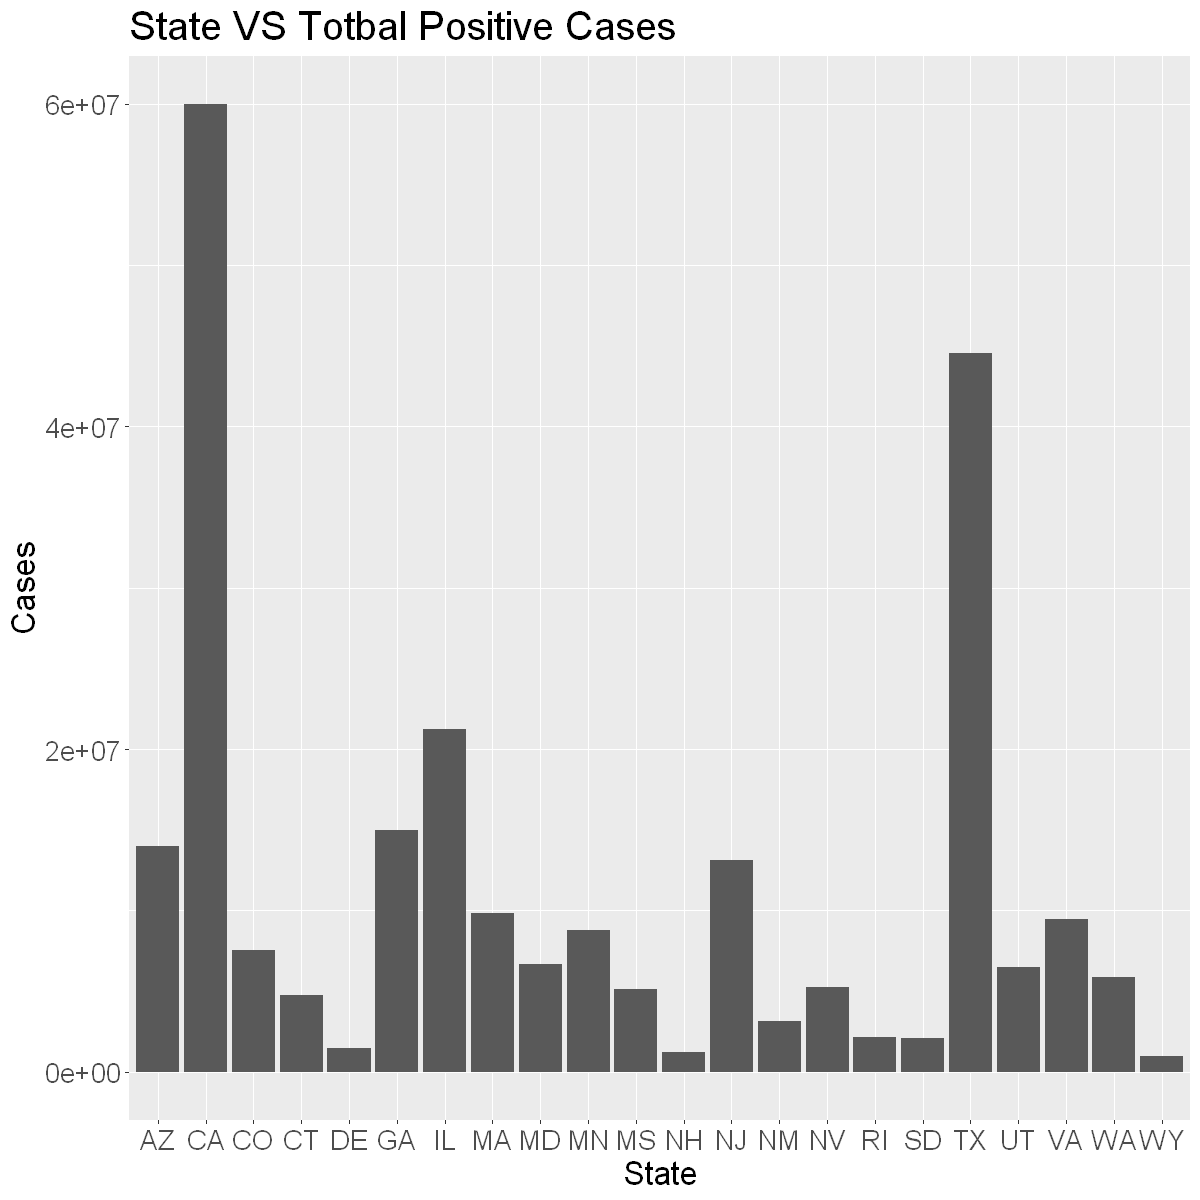

In [37]:
cases_plot <- ggplot(max_cases, aes(x = State, y = Cases)) + 
              geom_bar(stat = "identity") + 
              labs(title="State VS Totbal Positive Cases") +
              theme(text = element_text(size = 20))
cases_plot


By the plot above, total positive cases of California is significantly higher than other states, therefore, we would focus on California's data only , and calculate the proportion of different ethinicities getting tested positive for COVID-19 eg. for white, black, asian and latin people.

### 2.4 Compute estimates 

*Compute estimates of the parameter you identified across your groups. Present this in a table. If relevant, include these estimates in your plot.*

In [23]:
cali_prop <- cases_tidy %>%
              filter(State == "CA", Year == 2021) %>%
              summarize(total_pos = sum(Cases_Total),
                        p_white = sum(Cases_White) / sum(total_pos),
                        p_black = sum(Cases_Black) / sum(total_pos),
                        p_asian = sum(Cases_Asian) / sum(total_pos),
                        p_latin = sum(Cases_Latinx) / sum(total_pos)) %>%
               select(-total_pos) %>%
              pivot_longer(cols = 1:4,
                          names_to = "Ethnicity") %>%
              rename(proportion = value) 

cali_prop

Ethnicity,proportion
<chr>,<dbl>
p_white,0.15091456
p_black,0.03264898
p_asian,0.05050680
p_latin,0.41705729


Although, these statistics are of special case, as mentioned before attention is only given on these four races: `White`, `Black`, `Asian`, and `Latins`, hence, these proportions will not add up to 1, but when visualizing it, R have automatically tune it to sum to 1 ratio. Below is a visualization of these estimates:

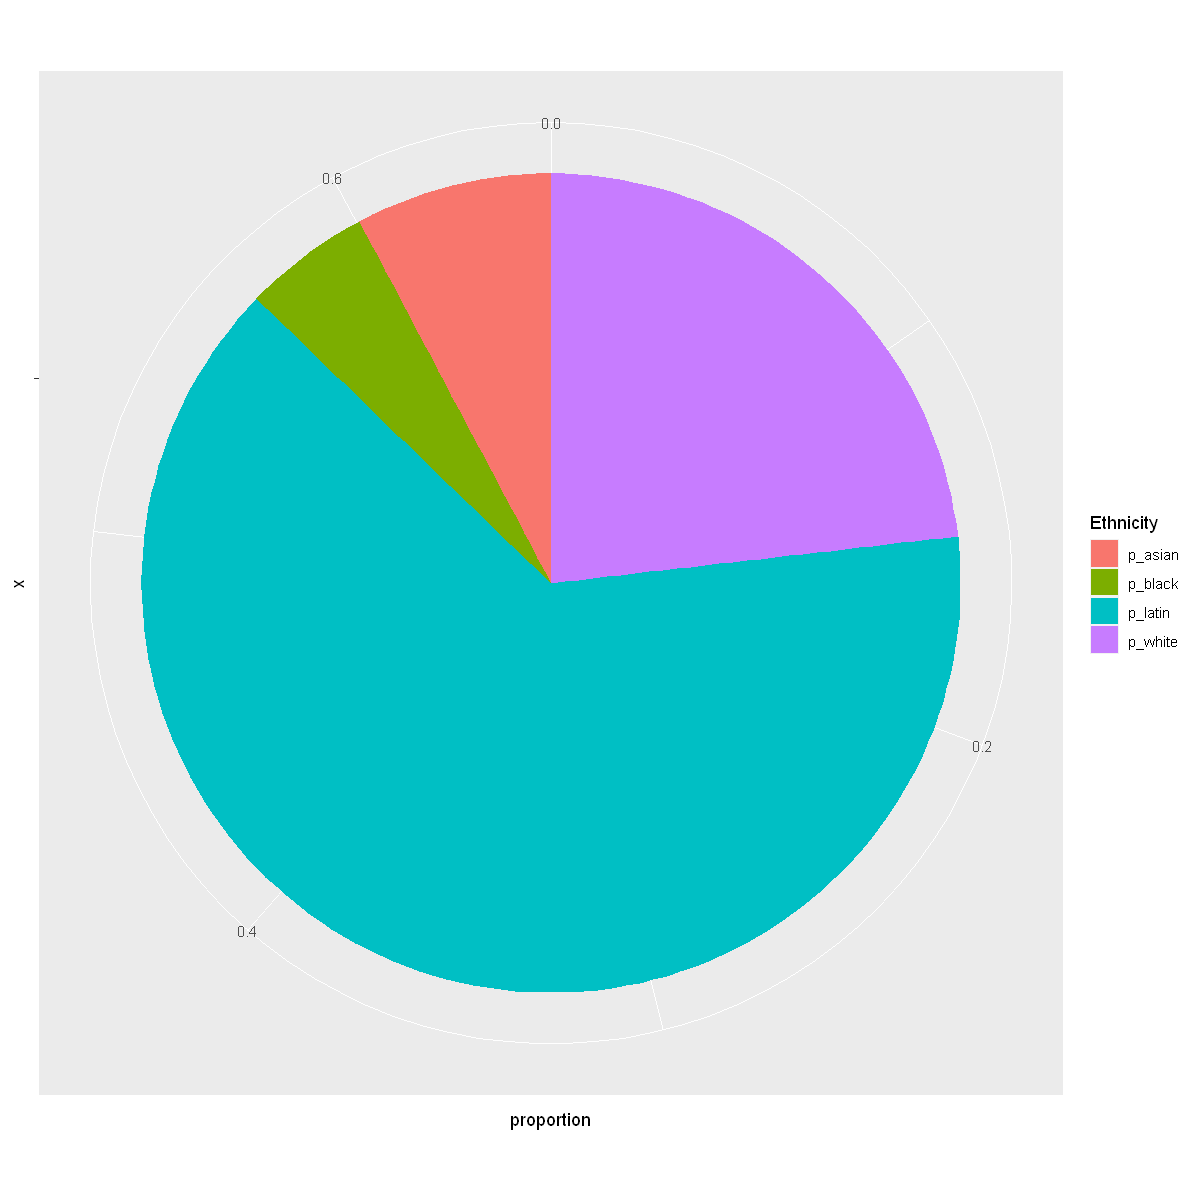

In [24]:
pie <- ggplot(cali_prop, aes(x = "", y = proportion, fill = Ethnicity)) +
     geom_bar(width = 1, stat = "identity") +
        coord_polar("y", start = 0)
pie

# 3. Methods: Plan

### 3.1 What do you expect to find?

Text

### 3.2 What impact could such findings have?

Text

### 3.3 What future questions could this lead to?

Text

## 4. Reference


About the Racial Data Tracker
https://covidtracking.com/race/about